<a href="https://colab.research.google.com/github/asheta66/CNN/blob/main/Node_Classification_with_Graph_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)
data_dir = os.path.join(os.path.dirname(zip_file), "cora")

168052/168052 [==============================] - 0s 1us/step


In [3]:
citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)
print("Citations shape:", citations.shape)

Citations shape: (5429, 2)


In [4]:
citations.sample(frac=1).head()

,target,source
4652,239810,359067
4593,227178,1128985
1077,5055,1104851
2650,28504,1153287
621,2654,1123926


In [5]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"), sep="\t", header=None, names=column_names,
)
print("Papers shape:", papers.shape)

Papers shape: (2708, 1435)


In [6]:
print(papers.sample(5).T)

                    2290             2405                    1649  \
paper_id           49844            60169                    6385   
term_0                 0                0                       1   
term_1                 0                0                       0   
term_2                 0                0                       0   
term_3                 0                0                       0   
...                  ...              ...                     ...   
term_1429              0                0                       0   
term_1430              0                0                       0   
term_1431              0                0                       0   
term_1432              0                0                       0   
subject    Rule_Learning  Neural_Networks  Reinforcement_Learning   

                      1896           2436  
paper_id             83746         167205  
term_0                   0              0  
term_1                   0             

In [7]:
print(papers.subject.value_counts())

Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: subject, dtype: int64


In [8]:
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

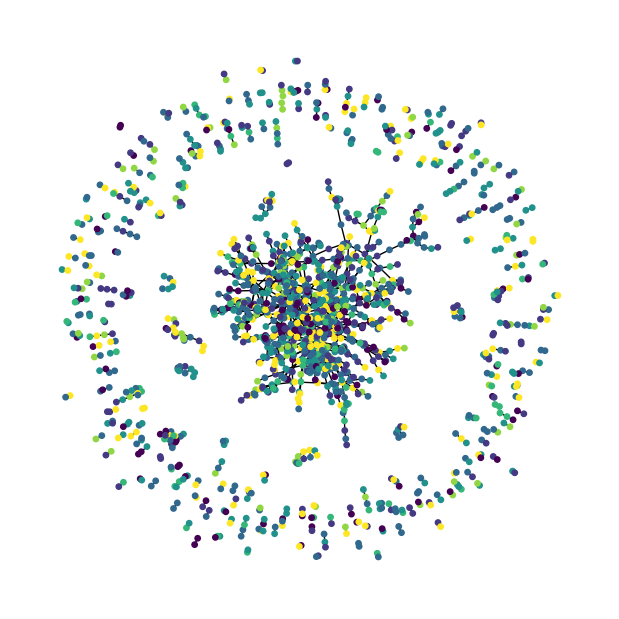

In [10]:
plt.figure(figsize=(6, 6))
colors = papers["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations.sample(n=1500))
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)

In [11]:
# Split the dataset into stratified train and test sets
train_data, test_data = [], []

for _, group_data in papers.groupby("subject"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (1319, 1435)
Test data shape: (1389, 1435)


In [12]:
# Implement Train and Evaluate Experiment
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

In [13]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

In [14]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

In [15]:
# Implement Feedforward Network (FFN) Module
# We will use this module in the baseline and the GNN models.

def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

In [ ]:
# Build a Baseline Neural Network Model
# Prepare the data for the baseline model
feature_names = set(papers.columns) - {"paper_id", "subject"}
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["subject"]
y_test = test_data["subject"]

In [17]:
# Implement a baseline classifier
# We add five FFN blocks with skip connections, so that we generate a baseline model
# with roughly the same number of parameters as the GNN models to be built later.

def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

Model: "baseline"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_features (InputLayer  [(None, 1433)]               0         []                            
 )                                                                                                
                                                                                                  
 ffn_block1 (Sequential)     (None, 32)                   52804     ['input_features[0][0]']      
                                                                                                  
 ffn_block2 (Sequential)     (None, 32)                   2368      ['ffn_block1[0][0]']          
                                                                                                  
 skip_connection2 (Add)      (None, 32)                   0         ['ffn_block1[0][0]',   

In [18]:
# Train the baseline classifier
history = run_experiment(baseline_model, x_train, y_train)

Epoch 1/300
5/5 [==============================] - 7s 162ms/step - loss: 3.8624 - acc: 0.1722 - val_loss: 1.9252 - val_acc: 0.1667
Epoch 2/300
5/5 [==============================] - 0s 30ms/step - loss: 2.7120 - acc: 0.2248 - val_loss: 1.9056 - val_acc: 0.1667
Epoch 3/300
5/5 [==============================] - 0s 32ms/step - loss: 2.3719 - acc: 0.2391 - val_loss: 1.8746 - val_acc: 0.3384
Epoch 4/300
5/5 [==============================] - 0s 33ms/step - loss: 2.1839 - acc: 0.2730 - val_loss: 1.8708 - val_acc: 0.4141
Epoch 5/300
5/5 [==============================] - 0s 30ms/step - loss: 1.9832 - acc: 0.2756 - val_loss: 1.8650 - val_acc: 0.4242
Epoch 6/300
5/5 [==============================] - 0s 30ms/step - loss: 1.9262 - acc: 0.3104 - val_loss: 1.8485 - val_acc: 0.3889
Epoch 7/300
5/5 [==============================] - 0s 31ms/step - loss: 1.7838 - acc: 0.3310 - val_loss: 1.8264 - val_acc: 0.3384
Epoch 8/300
5/5 [==============================] - 0s 26ms/step - loss: 1.7229 - acc: 0.3

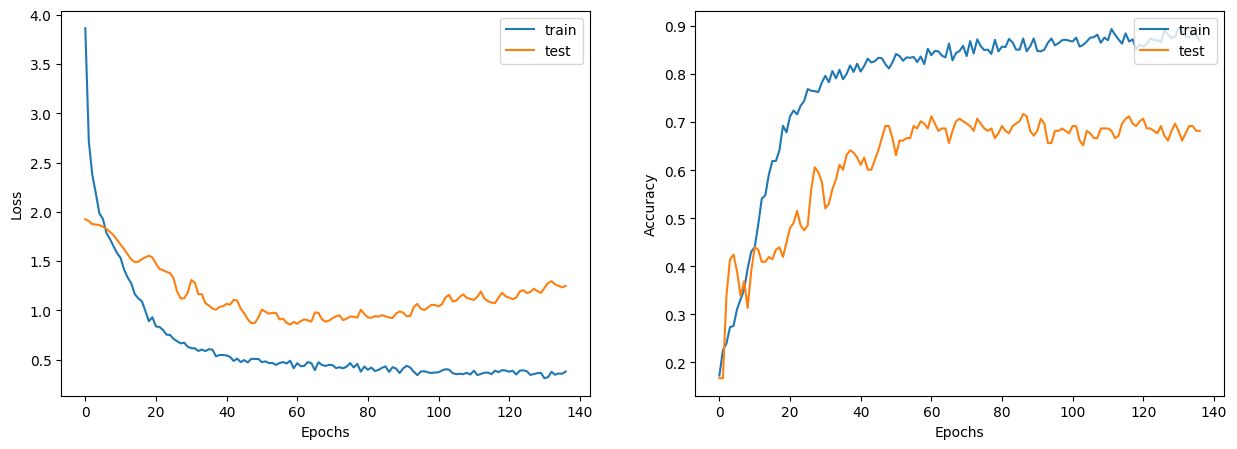

In [19]:
# Let's plot the learning curves.

display_learning_curves(history)

In [20]:
# Now we evaluate the baseline model on the test data split.

_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 74.23%


In [21]:
# Examine the baseline model predictions
# Let's create new data instances by randomly generating binary word vectors with respect to the word presence probabilities.

def generate_random_instances(num_instances):
    token_probability = x_train.mean(axis=0)
    instances = []
    for _ in range(num_instances):
        probabilities = np.random.uniform(size=len(token_probability))
        instance = (probabilities <= token_probability).astype(int)
        instances.append(instance)

    return np.array(instances)


def display_class_probabilities(probabilities):
    for instance_idx, probs in enumerate(probabilities):
        print(f"Instance {instance_idx + 1}:")
        for class_idx, prob in enumerate(probs):
            print(f"- {class_values[class_idx]}: {round(prob * 100, 2)}%")

In [22]:
# Now we show the baseline model predictions given these randomly generated instances.

new_instances = generate_random_instances(num_classes)
logits = baseline_model.predict(new_instances)
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

1/1 [==============================] - 0s 436ms/step
Instance 1:
- Case_Based: 0.02%
- Genetic_Algorithms: 98.98%
- Neural_Networks: 0.84%
- Probabilistic_Methods: 0.05%
- Reinforcement_Learning: 0.07%
- Rule_Learning: 0.02%
- Theory: 0.01%
Instance 2:
- Case_Based: 39.15%
- Genetic_Algorithms: 9.65%
- Neural_Networks: 2.94%
- Probabilistic_Methods: 2.98%
- Reinforcement_Learning: 0.99%
- Rule_Learning: 18.26%
- Theory: 26.03%
Instance 3:
- Case_Based: 1.0%
- Genetic_Algorithms: 6.74%
- Neural_Networks: 15.68%
- Probabilistic_Methods: 35.45%
- Reinforcement_Learning: 0.8%
- Rule_Learning: 0.38%
- Theory: 39.96%
Instance 4:
- Case_Based: 0.4%
- Genetic_Algorithms: 71.38%
- Neural_Networks: 1.15%
- Probabilistic_Methods: 0.41%
- Reinforcement_Learning: 25.92%
- Rule_Learning: 0.18%
- Theory: 0.57%
Instance 5:
- Case_Based: 0.01%
- Genetic_Algorithms: 99.37%
- Neural_Networks: 0.43%
- Probabilistic_Methods: 0.05%
- Reinforcement_Learning: 0.08%
- Rule_Learning: 0.01%
- Theory: 0.04%
Insta